In [1]:
#https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from pandas_datareader import data as web
from functools import reduce
from pycoingecko import CoinGeckoAPI

In [2]:
start = datetime(2020, 1, 1)
start_UNIX = datetime.timestamp(start)
end =  datetime.now()
end_UNIX = datetime.timestamp(end)

In [3]:
ids = ['bitcoin', 'ethereum','solana', 'chainlink']

In [4]:
cg = CoinGeckoAPI()
timePeriod = 1095.75
data = {}
for coin in ids:
    try:
        nested_lists = cg.get_coin_market_chart_by_id(
            id=coin, vs_currency="usd", days=timePeriod
        )["prices"]
        data[coin] = {}
        data[coin]["timestamps"], data[coin]["values"] = zip(*nested_lists)
    except Exception as e:
        print(e)
        print("coin: " + coin)

frame_list = [
    pd.DataFrame(data[coin]["values"], index=data[coin]["timestamps"], columns=[coin])
    for coin in ids
    if coin in data]

In [5]:
df_cryptocurrency = pd.concat(frame_list, axis=1).sort_index()
df_cryptocurrency["datetime"] = pd.to_datetime(df_cryptocurrency.index, unit="ms")
df_cryptocurrency["date"] = df_cryptocurrency["datetime"].dt.date
df_cryptocurrency = df_cryptocurrency.drop(['datetime'], axis=1)
df = df_cryptocurrency.set_index('date')

In [6]:
df = df.dropna()

In [7]:
returns = np.log(df / df.shift(1))

In [8]:
returns.head()

,bitcoin,ethereum,solana,chainlink
date,,,,
2020-04-11,NaN,NaN,NaN,NaN
2020-04-12,0.002050,0.003719,-0.199120,0.024981
2020-04-13,0.004985,0.003379,0.110044,0.042891
2020-04-14,-0.008078,-0.013706,-0.107497,-0.016862
2020-04-15,0.000385,0.009943,-0.165562,-0.038677


In [11]:
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (returns.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [12]:
print('Max sharpe ratio: {}'.format(sharpe_arr.max(())))
print('Location in array: {}'.format(sharpe_arr.argmax()))

Max sharpe ratio: [0.90644283 0.40963906 0.60460842 ... 0.77004157 0.68042268 0.70691652]
Location in array: 2837


In [13]:
#Check allocation weights
print(all_weights[5249,:])
x = all_weights[5249,:]
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

[0.407694   0.15527157 0.22478994 0.21224449]


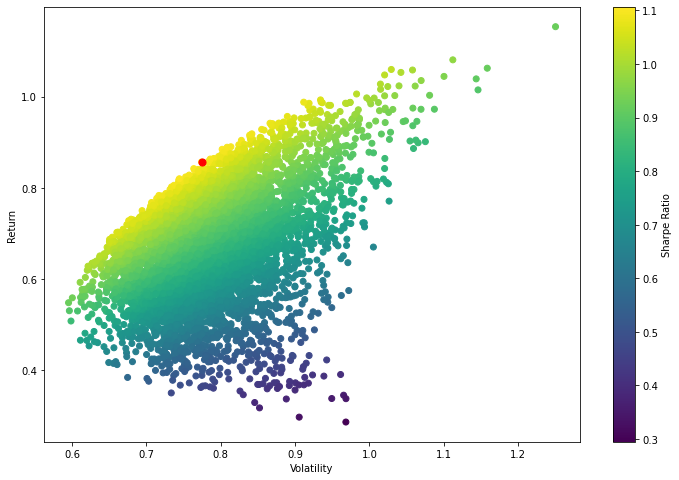

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

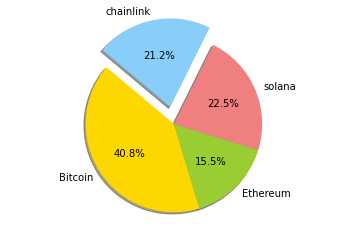

In [15]:
labels = 'Bitcoin', 'Ethereum','solana', 'chainlink'
sizes = x
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.2) # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()